# DIY Retirment Planning with Utility Maximization

In [ ]:
from retire import State, Decision, ConstantSpendStrategy
import retire.plots as rp

import numpy as np
import pandas as pd
from plotnine import *

## Phase 1: Meet Joe | Spreadsheets

Meet Joe. Joe is a young professional starting to think about retirement planning.

In [87]:
joe = State(age=30, assets=50_000, alive=True, retired=True)
standard_of_living = 50_000
working_income = 75_000

He's picked up a few rules of thumb like the **4% Rule**. The 4% rule advises that a "normal" 30 year retirement should start with a fund large enough that the first year's withdrawl is 4% of the total. He's also heard that, to get to this stage by the "normal' retirement age (mid 60s), he should have [1x/3x/6x](https://www.fidelity.com/viewpoints/retirement/how-much-do-i-need-to-retire) of his annual salary saved by 30/40/50.

Joe's main financial tool at this stage is a **spreadhseet**. A few times a year Joe consolidates his savings and expense accounts, breaks down spending by category, measures his annual saving rate, etc. Spreadsheets work best in two modes:

 1. Understanding who Joe is right now, by consolidating and organizing his current financial state.
 1. Performing simple projections into the future. 
    
Congratulations, Joe. You are on the path to financial literacy and security.


## Phase 2: A Multitude of Joes | Simulation

Joe is curious by nature. He's heard that the 4% rule is [rooted a study](https://en.wikipedia.org/wiki/Trinity_study) designed mainly to protect against running out of money, even in bad outcomes. He starts to wonder what the range of plausible retirements looks like. His spreadsheets can *kind* of explore questions like this, but it gets cumbersome. 

Joe adds **simulation** to his financial toolset. Monte Carlo simulations are really great at distilling the consequence of (arbitrarily complex) strategies, in uncertain environments. He starts with a simple exploration of the 4% Rule retirement. In each simulated year:
 * Joe becomes 1 year older
 * He spends $50k
 * His portfolio will grow or shrink based on a random sample of historical returns in the stock and bond markets
 * His portfolio will be adjusted for inflation (keeping everything in "present day" dollars). 
 * Based on actuarial data, he has a chance of dying (sorry, Joe).

In [90]:
np.random.seed(1)
# Ready to retire at 65, with enough assets to satisfy the 4% rule.
old_joe = State(age=65, assets=1_250_000, alive=True, retired=True)
(
    ConstantSpendStrategy(standard_of_living=standard_of_living, stock_fraction=stock_fraction)
    .simulate(old_joe, steps=30)
    [['age', 'alive', 'spend', 'assets']]
)

Simulating outcome:   0%|          | 0/1 [00:00<?, ?it/s]

,age,alive,spend,assets
0,65,True,50000.0,1.250000e+06
1,66,True,50000.0,9.809005e+05
2,67,True,50000.0,1.135454e+06
3,68,True,50000.0,1.205110e+06
4,69,True,50000.0,1.383348e+06
5,70,True,50000.0,1.302982e+06
6,71,True,50000.0,1.285865e+06
7,72,True,50000.0,1.472314e+06
8,73,True,50000.0,1.694028e+06
9,74,True,50000.0,1.566383e+06


Joe lived until 87, leaving $1.7M to his heirs. Good for you, Joe, rest in peace. Of course, this is just one of the plausible outcomes. The power of simulation is in understanding the distribution of plausible outcomes.

Simulating outcome:   0%|          | 0/100 [00:00<?, ?it/s]

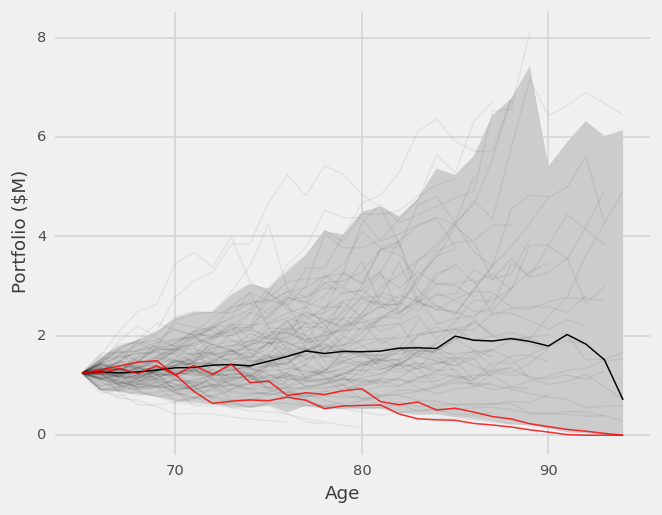

<ggplot: (165937976254)>

In [55]:
np.random.seed(1)
joes = (
    ConstantSpendStrategy(standard_of_living=standard_of_living, stock_fraction=stock_fraction)
    .simulate(old_joe, steps=30, simulations=100)
)
rp.plot_retirement_assets(joes, standard_of_living=50_000)

Each light grey line in this plot is a simulated timeline. The background band shows the spread of outcomes (it contains 95% of the timelines). The black line is the median outcome. The red lines are unlucky timelines where the 4% strategy did't sustain a $50k standard of living.

This is eye-opening for Joe. First, he understands that the 4% rule is indeed safe -- only 2% of his simulated timelines ended in failure. But look at that spread of outcomes! His retirement fund could feasibly triple in his retirement, leaving a huge sum of money unspent. Sure he can leave that money to his heirs, but it feels like a lost opportunity to not put *some* of that good fortune into use while he's still around to enjoy it. 

Simulations encourage exploration, so he starts playing around with different strategies. He starts guessing when it's safe to increase retirement spending:

Simulating outcome:   0%|          | 0/100 [00:00<?, ?it/s]

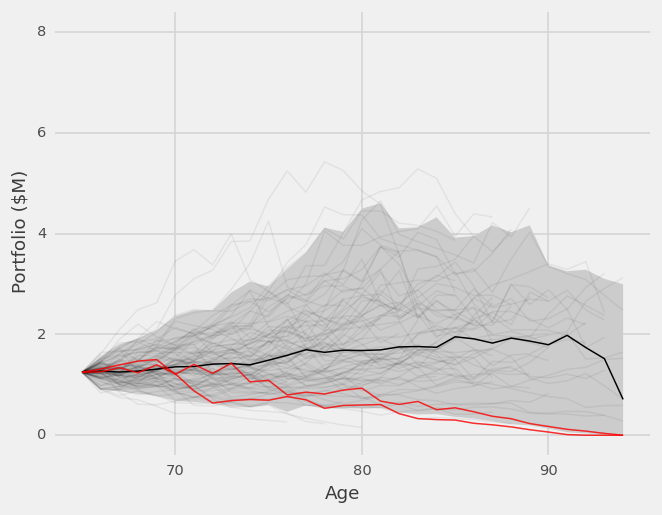

<ggplot: (165940419106)>

In [92]:
class GoodFortuneSpending(ConstantSpendStrategy):
    
    def decide(self, state):
        if state.age > 80 and state.assets > 2_500_000:
            # Safe to spend more
            spend = 0.08 * state.assets
        else:
            spend = min(state.assets, self.standard_of_living)
        return Decision(retire=True, save=-spend, spend=spend), 1
    
np.random.seed(1)

(
    GoodFortuneSpending(standard_of_living=standard_of_living, stock_fraction=stock_fraction)
    .simulate(old_joe, 30, simulations=100)
    .pipe(rp.plot_retirement_assets, standard_of_living=50_000)
    + scale_y_continuous(limits=[0, 8])
)

That certainly looks better. But now Joe can't help but wonder what the "best" strategy is, given his preference to spend down his retirement. 

### Phase 3: The Best Joe | Optimization and Recursive Utility

Joe starts thinking about what an optimal retirement strategy looks like. He finds a [white paper](https://static.fmgsuite.com/media/documents/9ad7d093-e34e-4de3-8379-8df31aa5d14f.pdf) by JP Morgan that talks about dynamic retirement strategies. He reads the [Wikipedia page](https://en.wikipedia.org/wiki/Epstein%E2%80%93Zin_preferences) on recursively defined utitility functions. He's surging up the Dunning Kruger curve, and it's exhilirating. He distills a few highlights from this armchair research:

 * Any optimization task needs some kind of score function to maximize or minimize. In economics people tend to call this "utility". 
 * Financial decisions often have two forms of utility: the immediate value of the decision (say, happiness generated from spending money), and the indirect effect it has on future decisions (leaving more or less money available for future expenses). The immediate value is subjective, but it's at least *known*. The indirect effect is probabilistic, since the future is also influenced by random events.
 
Joe has been thinking about simulations in terms of states (his portfolio) and decisions (whether to retire, how much to spend). The utility of this system is broken down as follows:
  * Terminal states (the ones with now further decisions, i.e. the ones where Joe dies) are given an explicit utility function that Joe defines.
  * The utility of a non-terminal state is equal to the highest-utility decision available from that state.
  * The utility of a decision has two parts:
     * The immediate value of the decision (another function that Joe defines to express his preferences), 
     * A probability-weighted aggregation of the utilities of states the decision can evolve to.
     
That last component could be as simple as a sum and expected value:
$$U(D) = U_{\rm instant}(D) + \sum_{P_i,S_i \in Outcomes(D)} P_i \times U(S_i)$$   

In practice finance people tend to include some additional terms to express preferences for less uncertainty (lower variance in $U(S)$ and utility delivered sooner -- something like

$$U(D) = U_{\rm instant}(D) + \beta \left(\sum_{P_i,S_i \in Outcomes(D)} P_i \times U(S_i)^\rho\right)^{1/\rho}$$   

where $\beta$ and $\rho$ are contants between 0 and 1, and lower values penalize delayed or uncertain rewards. But it's not terribly relevant at the moment.

Systems like this can be solved with dynamic programming -- working backwards from the terminal states (where utility is simple), and finding the optimial paths through a state space grid. 

Joe converts his preferences to something quantitative:

```python
def terminal_utility(state):
    return 0  # An extreme "you can't take it with you" preference.

def instant_utility(decision):
    return (
        np.log(deicsion.spend)                                # More money is better, but in a diminishing way
        + (3 * if decision.retire else 0)                     # Being retired is pretty great
        + (60 if decision.spend > standard_of_living else 0)  # Funding a standard of living is VERY important.
    )
```

And that's it -- from there, each "decision" is just the one with the maximum utility as discussed above. This is more expensive to compute, but it's tractable. Meet the best Joe.

In [47]:
from retire import StableRetirement
strategy = StableRetirement(standard_of_living=standard_of_living)
best_joes = strategy.simulate(old_joe, 30, simulations=100)

Solving optimal strategy:   0%|          | 0/91 [00:00<?, ?it/s]

Optimizing Age=120:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=119:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=118:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=117:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=116:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=115:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=114:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=113:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=112:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=111:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=110:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=109:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=108:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=107:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=106:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=105:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=104:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=103:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=102:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=101:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=100:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=99:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=98:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=97:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=96:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=95:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=94:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=93:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=92:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=91:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=90:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=89:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=88:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=87:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=86:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=85:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=84:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=83:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=82:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=81:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=80:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=79:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=78:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=77:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=76:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=75:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=74:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=73:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=72:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=71:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=70:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=69:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=68:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=67:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=66:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=65:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=64:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=63:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=62:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=61:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=60:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=59:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=58:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=57:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=56:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=55:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=54:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=53:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=52:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=51:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=50:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=49:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=48:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=47:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=46:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=45:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=44:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=43:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=42:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=41:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=40:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=39:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=38:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=37:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=36:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=35:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=34:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=33:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=32:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=31:   0%|          | 0/120 [00:00<?, ?it/s]

Optimizing Age=30:   0%|          | 0/120 [00:00<?, ?it/s]

Simulating outcome:   0%|          | 0/100 [00:00<?, ?it/s]

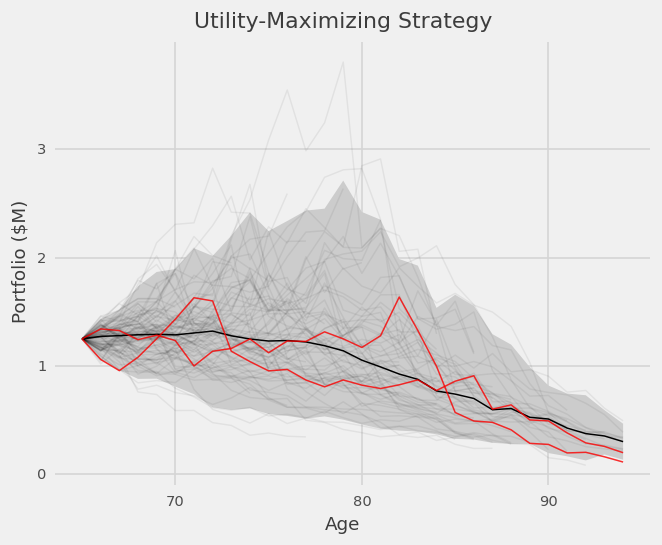

<ggplot: (165939311731)>

In [61]:
rp.plot_retirement_assets(best_joes, standard_of_living=standard_of_living) + labs(title='Utility-Maximizing Strategy')

C:\Users\Chris\miniconda3\envs\pf\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


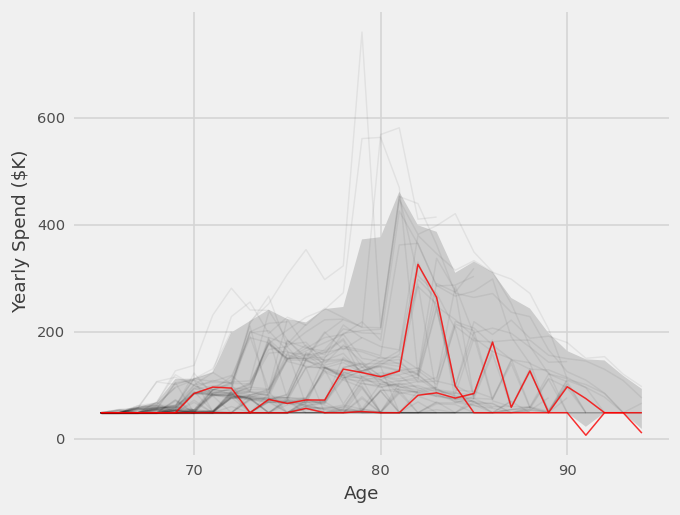

<ggplot: (165941593432)>

In [93]:
rp.plot_spend_timeline(best_joes, standard_of_living=standard_of_living)

There's no simple mathematical form for the decision strategy here -- it's the one which optimizes utility. But we can connect the features of these plots to aspects of the utility model:

 * The strategy is similarly risk-averse to the 4% rule -- 2% of simulations end in failure. This is driven by the strong utility incentive to spend at least the standard of living every year.
 * The strategy finds ways to safely spend down a large fund -- a combination of the instant utility associated with spending, as well as the lack of incentive to die with any leftover money.
 
As a bonus, and unlike the 4% rule, this approach can optimize *any* aspect of decision making. For example not just how much to spend in retirement, but when to retire and how much to save pre-retirement. Recall that Joe makes $75K/year. He can plan out his pre-retirement journey with the same optimized strategy.

In [94]:
# Note: we are starting younger, with a smaller retirement fund and not yet retired.
young_joe = State(age=30, assets=50_000, retired=False, alive=True)
young_sim = strategy.simulate(young_joe, 70, simulations=100)

Simulating outcome:   0%|          | 0/100 [00:00<?, ?it/s]

Each simulation decides when to flip from retired=False->True. Joe is on track to retire around 55-60.

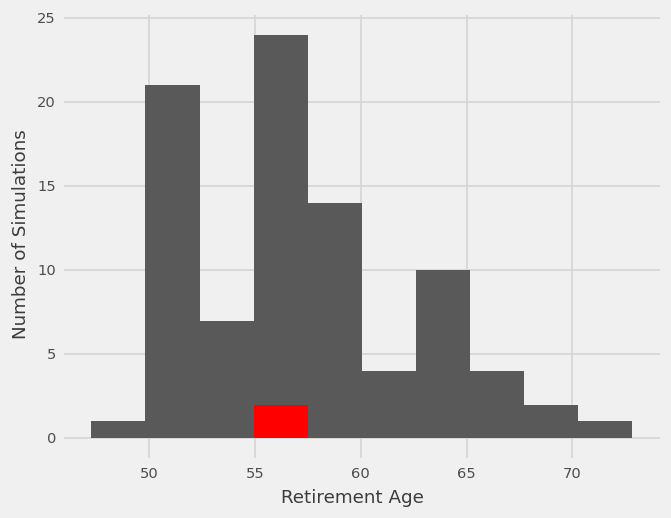

<ggplot: (165939341294)>

In [95]:
rp.plot_retirement_age(young_sim, standard_of_living=standard_of_living)

He tends to build an initial portfolio up beyond the 4% rule ($1.25M), especially if retiring earlier when the portfolio needs to last longer:

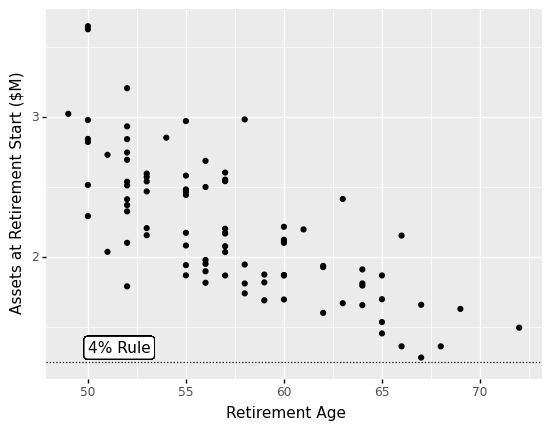

<ggplot: (165939315679)>

In [97]:
(
    young_sim
    .query('retired==True')
    .groupby('simulation')
    .apply(lambda df: pd.Series(dict(retirement_age=df.age.min(), starting_assets=df.iloc[0].assets)))
    .pipe(ggplot)
    + aes(x='retirement_age', y='starting_assets / 1e6')
    + geom_point()
    + geom_hline(yintercept=1.25, linetype='dotted')
    + geom_label(x=50, y=1.3, label='4% Rule', ha='left', va='bottom')
    + labs(
        x = 'Retirement Age',
        y = 'Assets at Retirement Start ($M)'
    )
)

This strategy prefers stock-heavy portfolios, although it does shift slightly towards bonds later in life.

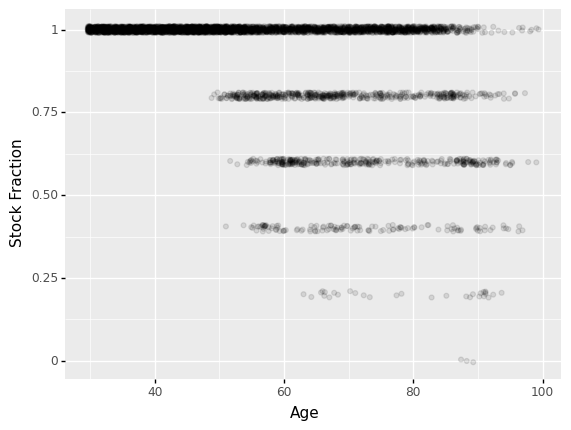

<ggplot: (165941496113)>

In [74]:
(
    young_sim.dropna()
    .pipe(ggplot)
    + aes(x='age', y='stock_fraction')
    + geom_point(alpha=0.1, position=position_jitter(height=0.01))
    + labs(x='Age', y='Stock Fraction')
)

## You are not Joe

These simulations are "optimal" only to the extent that the simulation of uncertain outcomes, and the expression of preferences via utilities, is sensible. Both of these are utlimately subjective and personal decisions. You are not Joe, and your best strategy is likely different. Nevertheless, focusing on describing utility and uncertainty, instead of strategies and rules, strikes me as a lovely way to think about planning.

In [2]:
#This makes the notebook pretty

from IPython.core.display import HTML
def css_styling():
    styles = open('custom.css', 'r').read()
    return HTML(styles)
css_styling()